# E-tivity 3: Clustering and Manifold Learning
### MSc in AI - CE6002 & CS5062 
Student Name: Michel Danjou

Student ID: 18263461

Use this notebook to complete Tasks 1 and 2 in E-tivity3.

# Import Python Modules

In [1]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import manifold
from sklearn import cluster
from sklearn import preprocessing

# Task 1
  * Watch the StatQuest: MDS and PCoA video (also linked in module material section below). Note that the columns/cells in this video are the observations and the data rows/genes are the attributes.
  * Watch the video k-Means Clustering Algorithm (also linked in the module material section below).
  * Download the dataset loans_dataset_et3.csv. This is a subset of the loans dataset used in the example notebooks for E-tivity1 and E-tivity2 which has only the examples with loan status Yes and preselected features. 
  * Follow the examples in the notebook Lab 3 - Clustering and Manifold Learning.ipynb to cluster loans_dataset_et3.csv with the k-Means clustering algorithm and visualise the clustering. Use an appropriate feature-scaling technique and pick a value of k suggested by MDS and t-SNE visualisations of the dataset. Experiment with various values of the parameters of k-Means. Aim at producing a meaningful clustering that allows you to describe the clusters with words. Write a short conclusion about the characteristics of the clusters (max 250 words).

## 1.1 Load and scale the data

In the next cell we will be performing the following operations:
  * load the csv file into a panda dataset.
  * convert the data to a Numpy array
  * scale the data fro the Numpy array

In [3]:
# Load the data
df = pd.read_csv("loans_dataset_et3.csv")  
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,332.000000,332.000000,332.000000,332.000000,332.000000
mean,5201.093373,1495.508795,140.882530,341.710843,0.978916
std,4584.815491,1982.742932,75.544237,61.651497,0.143882
min,645.000000,0.000000,17.000000,60.000000,0.000000
25%,2912.750000,0.000000,100.000000,360.000000,1.000000
50%,3858.500000,1211.500000,128.000000,360.000000,1.000000
75%,5818.250000,2250.000000,162.000000,360.000000,1.000000
max,39999.000000,20000.000000,600.000000,480.000000,1.000000


In [4]:
df.head(5)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,2483,2466.0,90,180,0
1,4917,0.0,130,360,0
2,4106,0.0,40,180,1
3,3859,3300.0,142,180,1
4,6417,0.0,157,180,1


In [5]:
# Convert data to np array
df_data = np.array(df.values, dtype=float)

# Scale the data
min_max_scaler = preprocessing.MinMaxScaler()
df_data = min_max_scaler.fit_transform(df_data)

#### Investigate the effect of scaling on the dataset
The graph below hightlights the fact that the scaling preserved the shape of the data. 

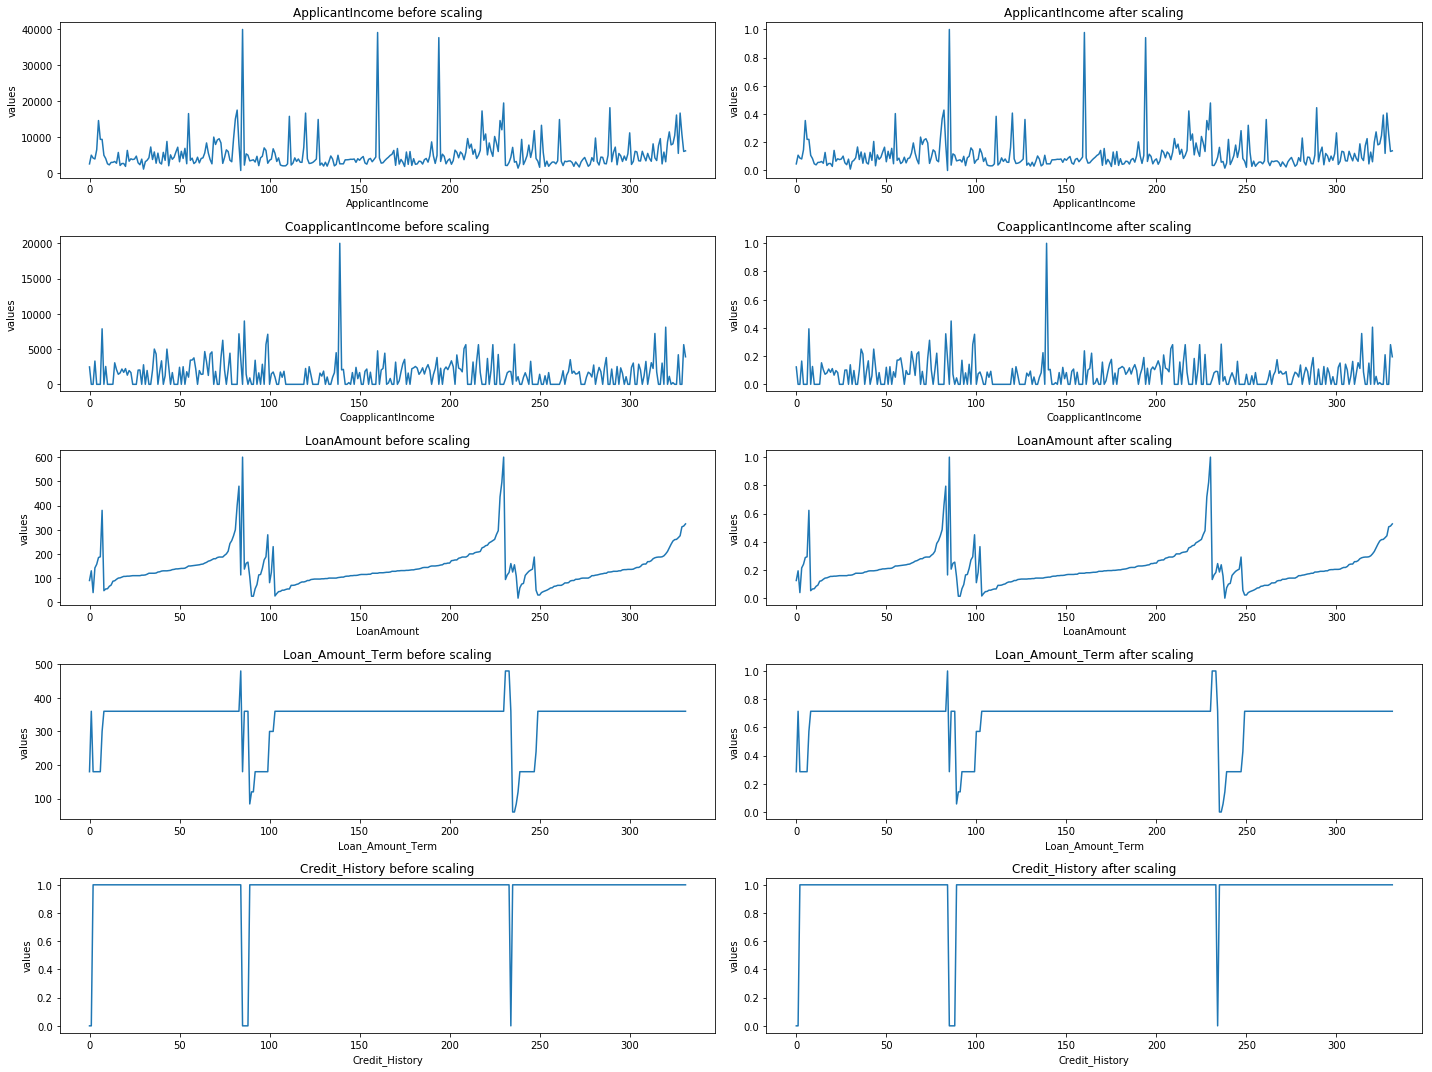

In [6]:
f, axs = plt.subplots(5, 2, figsize=(20, 15))
col_names = df.columns.values.tolist()

for i in range(5):
    
    plt.subplot(5, 2, 2*i+1)
    plt.plot(df.iloc[:,i])
    plt.xlabel(col_names[i])
    plt.ylabel('values')
    plt.title(col_names[i] + " before scaling")

    plt.subplot(5, 2, 2*i+2)
    plt.plot(df_data[:,i])
    plt.xlabel(col_names[i])
    plt.ylabel('values')
    plt.title(col_names[i] + " after scaling")

plt.tight_layout()
plt.show()

#### Search for correlated features by displaying the coorelation matrix
The correlation matrix below shows that the `LoanAmount` is correlated to the `ApplicantIncome` and to a lesser extend to the `CoapplicantIncome`

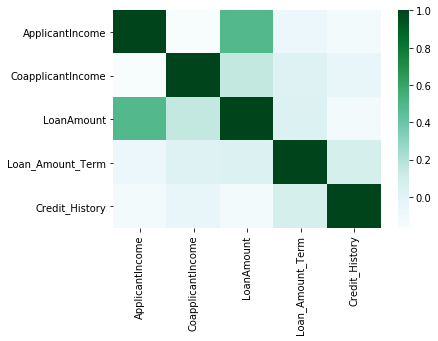

In [7]:
sns.heatmap(df.corr(), cmap='BuGn')

# 1.2  Clustering and Manifold

In [8]:
# Scatter plot
colors = np.array(['orange', 'blue', 'lime', 'grey', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    # plot the examples, i.e. the data points
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## KMeans clustering

In [9]:
max_nb_cluters = 10

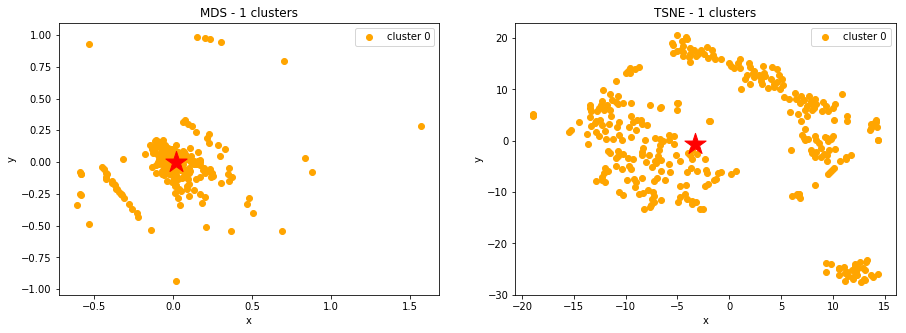

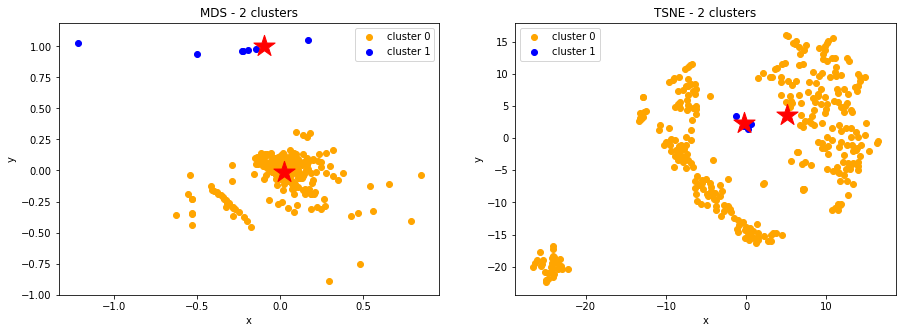

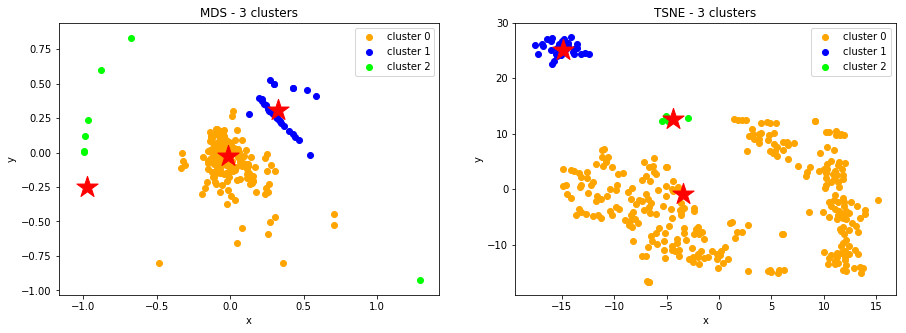

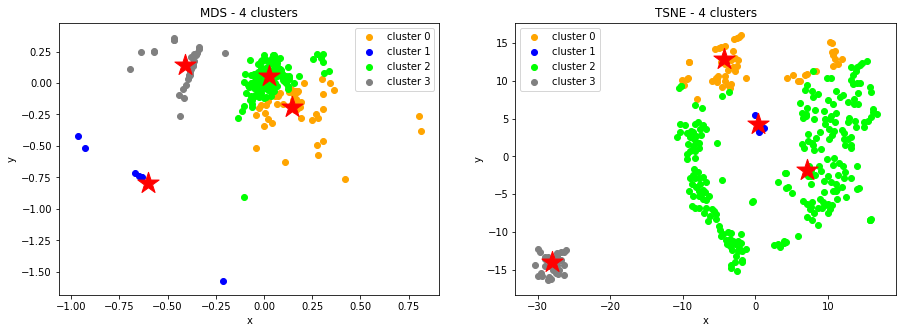

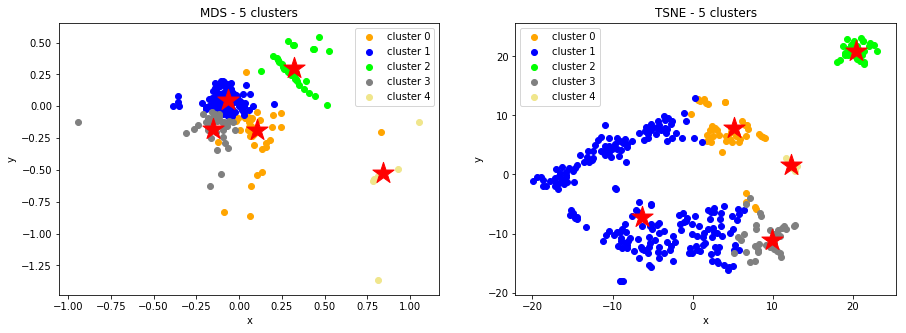

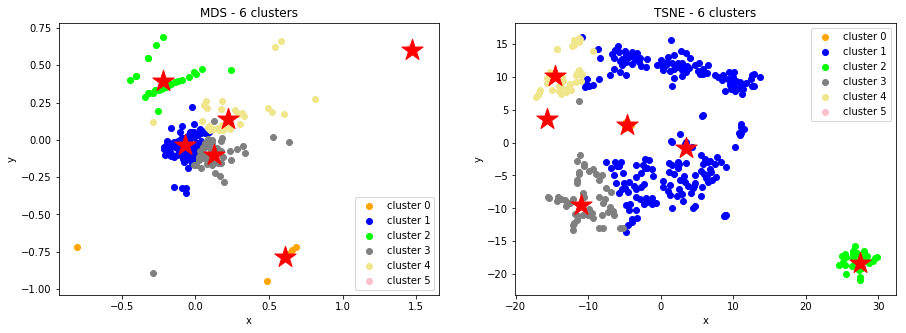

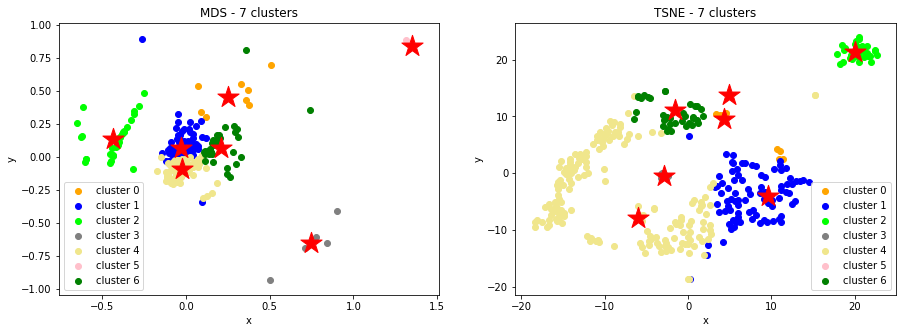

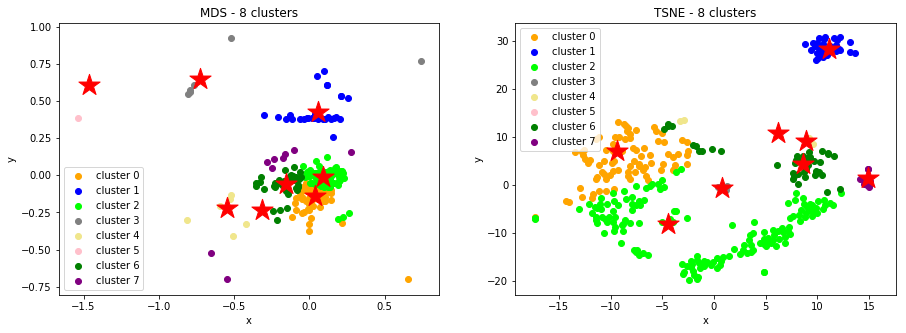

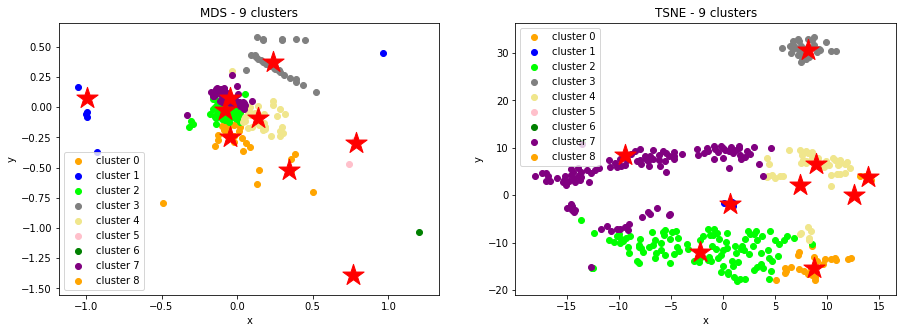

In [10]:
k_means_cache = []

for k in range(1, max_nb_cluters):
    # Run KMeans algorithm
    clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(df_data)
    k_means_cache.append(clustered_data_sklearn)
    
    # Create new array composed of data + k centers 
    df_data_and_centers = np.r_[df_data,clustered_data_sklearn.cluster_centers_]

    f, axs = plt.subplots(1, 2, figsize=(15, 5))

    # MDS
    plt.subplot(1, 2, 1)
    XYcoordinates = manifold.MDS(n_components=2).fit_transform(df_data_and_centers)
    clustering_scatterplot(points=XYcoordinates[:-k,:], 
                           labels=clustered_data_sklearn.labels_, 
                           centers=XYcoordinates[-k:,:], 
                           title='MDS - ' + str(k) + ' clusters')

    # TSE
    plt.subplot(1, 2, 2)
    XYcoordinates = manifold.TSNE(n_components=2).fit_transform(df_data_and_centers)
    clustering_scatterplot(points=XYcoordinates[:-k,:], 
                           labels=clustered_data_sklearn.labels_,
                           centers=XYcoordinates[-k:,:], 
                           title='TSNE - ' + str(k) + ' clusters')

    plt.show()


In [11]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,cluster
0,2483,2466.0,90,180,0,1
1,4917,0.0,130,360,0,1
2,4106,0.0,40,180,1,3
3,3859,3300.0,142,180,1,3
4,6417,0.0,157,180,1,3


In [12]:
df.tail()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,cluster
327,5417,4196.0,267,360,1,0
328,16666,0.0,275,360,1,4
329,10750,0.0,312,360,1,4
330,5955,5625.0,315,360,1,0
331,6133,3906.0,324,360,1,0


In [13]:
#df.groupby('cluster').mean()
df.groupby('cluster').mean().sort_values(by=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], ascending=False)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
cluster,,,,,
6,39999.000000,0.000000,600.000000,180.000000,0.0
5,38433.000000,2375.000000,136.000000,360.000000,1.0
8,14303.000000,1433.200000,482.400000,360.000000,1.0
4,10096.441860,377.116279,203.604651,358.604651,1.0
3,5146.966667,1297.126666,116.333333,161.600000,1.0
0,5048.043478,5666.173913,216.565217,357.391304,1.0
7,4148.432432,264.757838,98.297297,360.540541,1.0
1,4013.000000,2447.833333,140.666667,330.000000,0.0
2,3145.657658,2297.891892,130.702703,362.702703,1.0


We can see that 
  * the higher the sum of the `ApplicantIncome` and `CoapplicantIncome`, the higher the `LoanAmount`
  * the bank loans large amount of money even if there is no `Credit_History`
  * the loan values are small compared to the income
  * assuming that the loan terms are expressed in months, the terms are between 13 and 30  years.

# Task 2

##   2.1 Plot
*Plot the sum of squared distances from the data points (in loans_dataset_et3.csv) to the centers of the k-Means clusters for various values of k. Use the Elbow method to pick the best value of k. Attempt also another method for determining the best value of k. If these methods suggest a different value of k (from the one you used in Task 1), then compute a new k-Means clustering.*

### Leveraging inertias metrics to find best k

k:0, inertia:27.287863801543914:
k:1, inertia:20.222308926176684:
k:2, inertia:14.041065598451198:
k:3, inertia:10.509871849242854:
k:4, inertia:9.106862340891112:
k:5, inertia:7.690198885834333:
k:6, inertia:6.654846285665589:
k:7, inertia:5.727491254533664:
k:8, inertia:4.960969571094117:
all_inertias:{} [27.287863801543914, 20.222308926176684, 14.041065598451198, 10.509871849242854, 9.106862340891112, 7.690198885834333, 6.654846285665589, 5.727491254533664, 4.960969571094117]


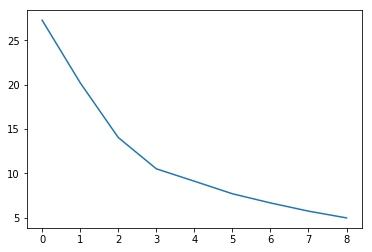

In [14]:
all_inertias = []
for kmean in range(len(k_means_cache)): 
    print("k:{}, inertia:{}:".format(kmean, k_means_cache[kmean].inertia_ ))
    all_inertias.append(k_means_cache[kmean].inertia_)
    
print("all_inertias:{}", all_inertias)
plt.plot(all_inertias)

We can see an elbow for k=3. Since k starts at 0 is for a cluster of 1, then the elbow is for nb_cluster = 4

<span style="color:red">TODO: Add labels & Title</span>


### Alternative approach for finding best k
Here we manually calculate the distance between points and their respective center.

Reference: http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/


all_distances: [0.20655356071245645, 0.18908037409626496, 0.15600669330231778, 0.1327202335141141, 0.12276988675439608, 0.11774242882565499, 0.10957631324677083, 0.10282568302870536, 0.09439667653766387]


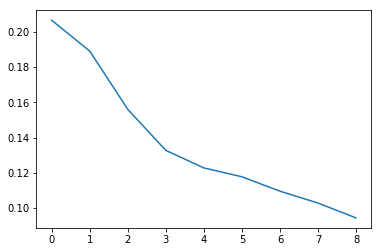

In [15]:
def create_scaled_df(clustered_data_sklearn, nb_clusters):
    scaled_df = pd.DataFrame(df_data, columns=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'])
    scaled_df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)
    scaled_df['nb_clusters'] = nb_clusters
    return scaled_df


def get_centers_for_cluster(row):
    nb_clusters = int(row['nb_clusters'])
    cluster = int(row['cluster'])
   
    return k_means_cache[nb_clusters].cluster_centers_[cluster]


def calculate_distance(row):
    centers = row['centers']
    
    distance = math.pow((row['ApplicantIncome'] - centers[0]),2)
    distance += math.pow((row['CoapplicantIncome'] - centers[1]),2)
    distance += math.pow((row['LoanAmount'] - centers[2]),2)
    distance += math.pow((row['Loan_Amount_Term'] - centers[3]),2)
    distance += math.pow((row['Credit_History'] - centers[4]),2)
    distance = math.sqrt(distance)

    return distance


def get_mean_distances():
    distances = []
    for kmean in range(len(k_means_cache)):
        current_k = kmean
        sdf = create_scaled_df(k_means_cache[kmean], kmean)
        sdf['centers'] = sdf.apply(get_centers_for_cluster, axis=1)
        sdf['distance'] = sdf.apply(calculate_distance, axis=1)
        distances.append(sdf['distance'].mean())

    return distances

all_distances = get_mean_distances()
plt.plot(get_mean_distances())
print("all_distances:", all_distances)


The above plot shows an elbow with k = 3+1 = 4
Let's plot the derivative to figure out more precisely how the slope of this curve behaves.

[-0.01747319 -0.03307368 -0.02328646 -0.00995035 -0.00502746 -0.00816612
 -0.00675063 -0.00842901]


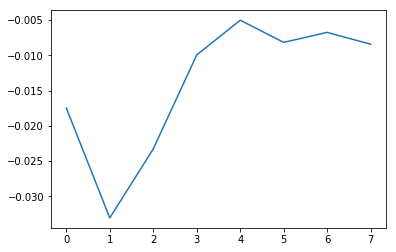

In [16]:
from numpy import diff
dx = 1
y = all_distances
dy = diff(y)/dx
print(dy)
plt.plot(dy)


We can see that the slope is negative but that around 4 is suddenly ceases to decrease. Since for slope is nearly the same for x=4,5,6, the elbow must be before that point at x=3. Since the index starts at 0, we can conclude that the elbow is obtained with **4 clusters**.

## Yet another way to find the best k

  * Course resource: https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
  * Scikit resource: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

### ADAPT THE CODE BELOW TO OUR NEEDS.

Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.
For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.56376469026194
For n_clusters = 6 The average silhouette_score is : 0.4504666294372765


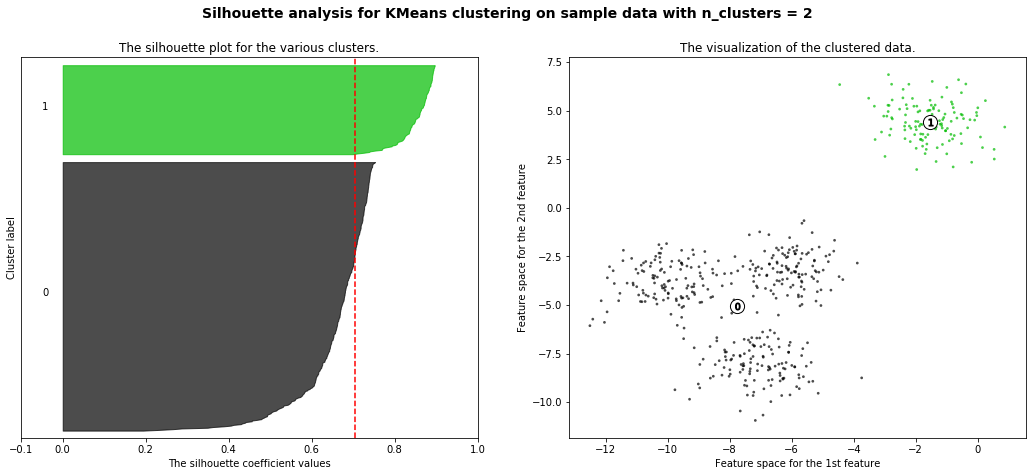

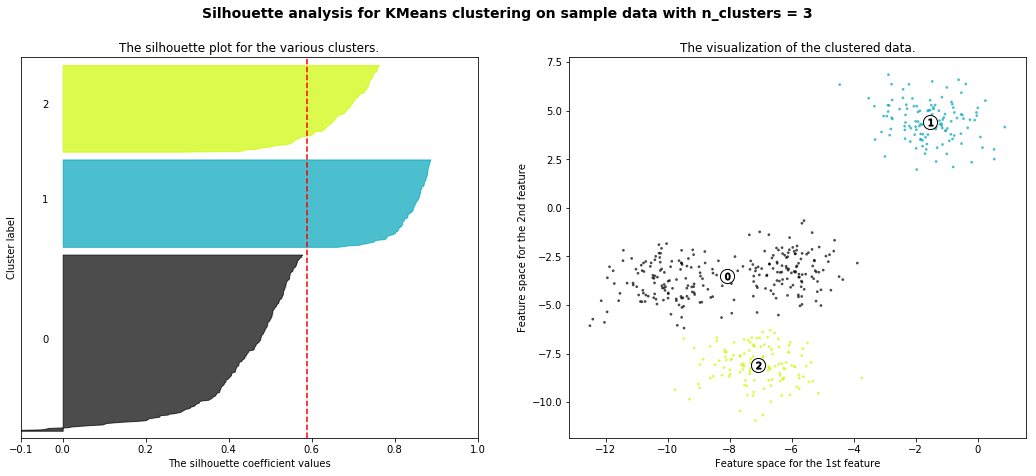

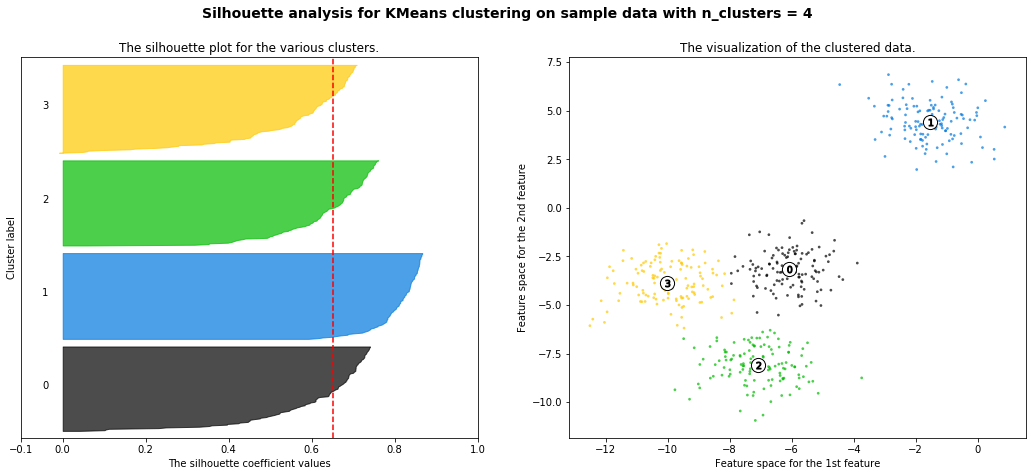

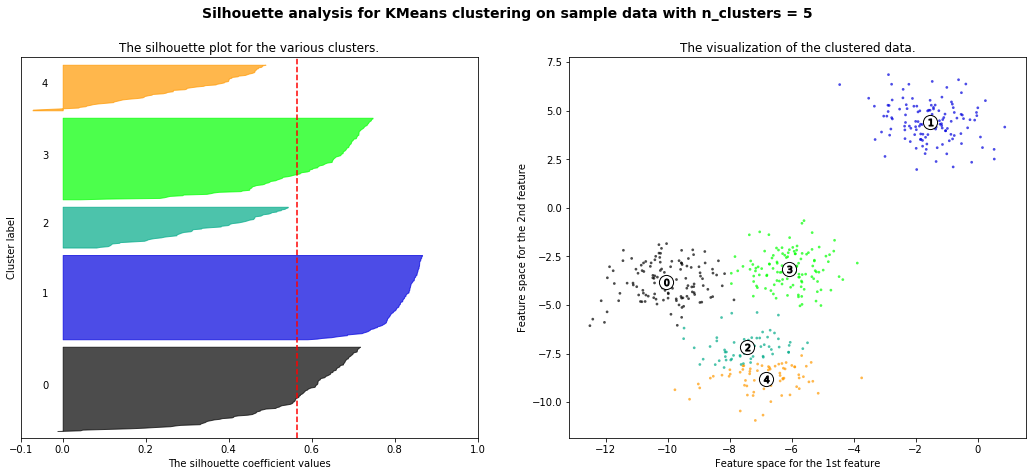

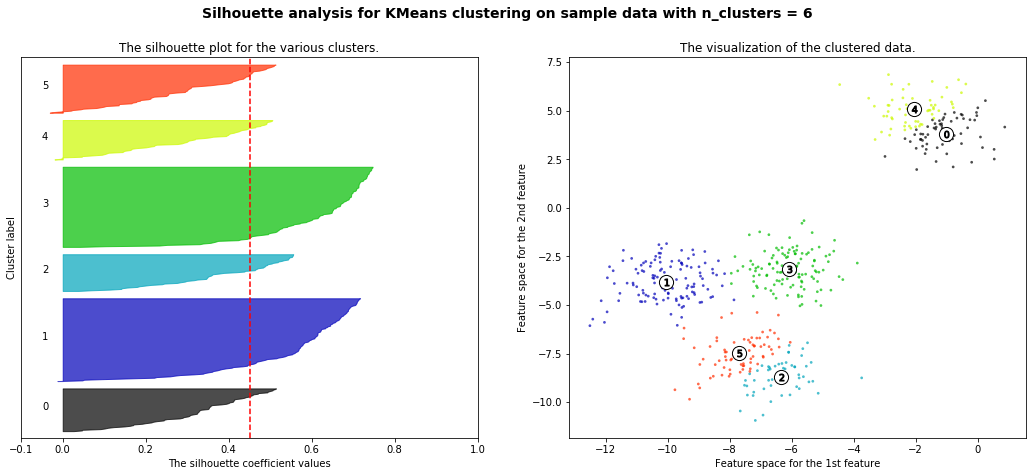

In [17]:

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## 2.2. Other clustering algorithm
*Use another clustering algorithm (from the ones available in scikit-learn) for the same dataset and an appropriate manifold-learning technique to visualise it.*

Reference: 
  * Clustering: https://scikit-learn.org/stable/modules/clustering.html
  * Manifold: https://scikit-learn.org/stable/modules/manifold.html


In [18]:
from sklearn.cluster import SpectralClustering
import numpy as np
X = np.array([[1, 1], [2, 1], [1, 0],
              [4, 7], [3, 5], [3, 6]])
clustering = SpectralClustering(n_clusters=2,
        assign_labels="discretize",
        random_state=0).fit(df_data)
print("clustering labels:", clustering.labels_)
print("clustering       :", clustering)
clustering 


clustering labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
clustering       : SpectralClustering(affinity='rbf', assign_labels='discretize', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=2, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=0)


SpectralClustering(affinity='rbf', assign_labels='discretize', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=2, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=0)

In [19]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

clustering = AgglomerativeClustering().fit(df_data)

print("clustering labels:", clustering.labels_)
print("clustering       :", clustering)

clustering labels: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
clustering       : AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x000001D3995849D8>)


## 2.3. Discussion
*Discuss the differences between the k-Means clustering and the clustering found by the second algorithm you have tried in words (max 250 words) and by visualising the clusterings with an appropriate manifold-learning technique.*